### All-sky AME vs. IR Scatter Plots

In [524]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from   scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle
from   pylab import arange, show, cm
from   scipy.stats import sigmaclip
from   scipy.stats import spearmanr

cmap = cm.rainbow
cmap.set_under('w')

%matplotlib inline

# 0.1) Load data and masks:

In [538]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)

    
planck_mw = planck_mw.drop('AMEfreq',axis=1)    

phot_mpsub_sclip = phot_mpsub.copy()
phot_mpsub_sclip = sigmaClip(phot_mpsub_sclip)


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [548]:
mask_all = hp.read_map('../Data/raw/masks/mask_all.fits', nest=True)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


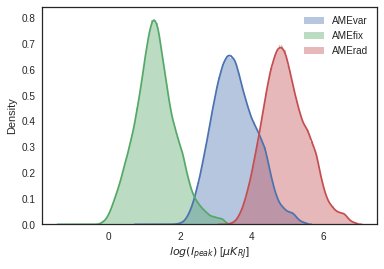

In [549]:
def plotClippedHist(data,sigma, log=False):
    c, upp, low = sigmaclip(data,sigma ,sigma)
    
    label = data.name
    
    with sb.axes_style("white"):
        if log == True:
            sb.distplot(np.log10(c), bins =300, label=label)
        else:
            sb.distplot(c, bins=300, label=label)
        
    plt.legend()
    
plotClippedHist(planck_mw['AMEvar'], 15, log=True)
plotClippedHist(planck_mw['AMEfix'], 15, log=True)
plotClippedHist(planck_mw['AMErad'], 15, log=True)
plt.xlabel('$log(I_{peak})$ [$\mu{}K_{RJ}]$')
plt.ylabel('Density')
plt.savefig('../Plots/ch_allsky/AME_comps_distplot.pdf')

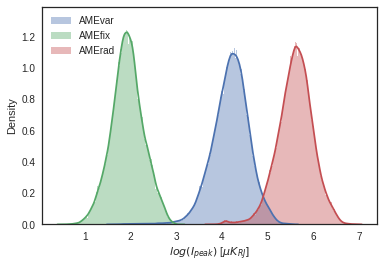

In [550]:
plotClippedHist(planck_mw['AMEvar'].iloc[mask_all!=hp.UNSEEN], 15, log=True)
plotClippedHist(planck_mw['AMEfix'].iloc[mask_all!=hp.UNSEEN], 15, log=True)
plotClippedHist(planck_mw['AMErad'].iloc[mask_all!=hp.UNSEEN], 15, log=True)
plt.xlabel('$log(I_{peak})$ [$\mu{}K_{RJ}]$')
plt.ylabel('Density')
plt.savefig('../Plots/ch_allsky/AME_comps_distplot_maskall.pdf')

In [551]:
plotClippedHist(
    np.log10(
        AMEfix_rad
    ), 
    5)

AttributeError: 'numpy.ndarray' object has no attribute 'name'

In [ ]:
hp.mollview(planck_mw['AMErad'], 
            norm  = 'log', 
            nest  = True, 
            cmap  = cmap,
            title = '')

In [ ]:
ancillframe = pd.DataFrame()

    
ancillframe['$N_{H}$'] = hp.ud_grade(
    hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/radio/lambda_combined_nh.fits',
                                  nest=True),
    nside_out =  256,
    order_in  = 'NESTED',
    order_out = 'NESTED',
    pess      =  True)


ancillframe['$H_{a}$'] = hp.ud_grade(
                               hp.read_map(
                                   '/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/radio/lambda_halpha_fwhm06_0512.fits',
                                           nest=True),
                               nside_out = 256, 
                               order_in = 'NESTED', 
                               order_out = 'NESTED' )

ancillframe['H408'] = hp.ud_grade(
                               hp.read_map(
                                   '/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/radio/haslam408_dsds_Remazeilles2014.fits',
                                           nest=True),
                               nside_out = 256, 
                               order_in = 'NESTED', 
                               order_out = 'NESTED' )
    
    

    
ancillframe_n64 = pd.DataFrame()

for i in ancillframe.columns:
    ancillframe_n64[i] =  hp.ud_grade(
            
            ancillframe[i].values,
            nside_out = 64,
            order_in = 'NESTED',
            order_out = 'NESTED')

ancillframe_n64['$AME_{wmap}$'] = hp.ud_grade(
                hp.read_map(
                    '/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/raw/wmap_mcmc_sd_k_spin_dust_temp_7yr_v4p1.fits',
                nest=True),
            nside_out = 64,
            order_in = 'NESTED',
            order_out = 'NESTED')


In [ ]:
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', 
     Imputer(strategy="median")),
    ('std_scaler', 
     StandardScaler(with_mean=False)),
])
# allsky_pipeline = Pipeline([
#     ('imputer', Imputer(strategy="median"))
# ])

phot_tr      = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)




### 1.1) Cross-correlation among all IR photometric bands and AME map
##### Split by Galactic Latitude

In [ ]:
glatrange     = 15.0
elatrange     = 10


gcut_l = np.where(
    (abs(coords['glat']) < glatrange) & 
    (abs(coords['elat']) > elatrange)
    )

gcut_h = np.where(
    (abs(coords['glat']) > glatrange) & 
    (abs(coords['elat']) > elatrange)
)



# Import and degrade NSIDE256 point source mask:

In [ ]:
def plotCorrMatrix(mapframe, pdf_suffix, pixmask):
    
    mapframe[pixmask==hp.UNSEEN] = np.nan
    
    mapframe_corr_hgl     = mapframe.iloc[gcut_h].dropna().corr(method='spearman')
    mapframe_corr_lgl     = mapframe.iloc[gcut_l].dropna().corr(method='spearman')
    



    with sb.axes_style("white"):


        fig, ax = plt.subplots(1,2,figsize=(18,9))
        #cbar_ax = fig.add_axes([.91, .2, .03, .7])

        sb.heatmap(
            mapframe_corr_hgl,
            #linewidths=.5,
            annot=True,
            cbar=False,
            yticklabels=True,
            xticklabels=True,
            ax = ax[0],
            vmin=0,
            vmax=1)

        ax[0].set_title("$|b| > 15^{\circ}$", fontsize=20)

        sb.heatmap(
            mapframe_corr_lgl,
            #linewidths=.5,
            annot=True,
            cbar=False,
            #cbar_ax=cbar_ax,
            yticklabels=True,
            xticklabels=True,
            ax=ax[1],
            vmin=0,
        #    vmax=1 ,cbar_kws={'label': 'Spearman $r$'}
        )

        ax[1].set_title("$|b| < 15^{\circ}$", fontsize=20)

        #cbar_ax.set_title("Spearman $r$")
        fig.tight_layout(rect=[0, 0, .9, 1])

        plt.show()

        fig.savefig("../Plots/ch_allsky/all_bands_corr_matrix_wAME_spearman{}.pdf".format(pdf_suffix), bbox_inches='tight')
        

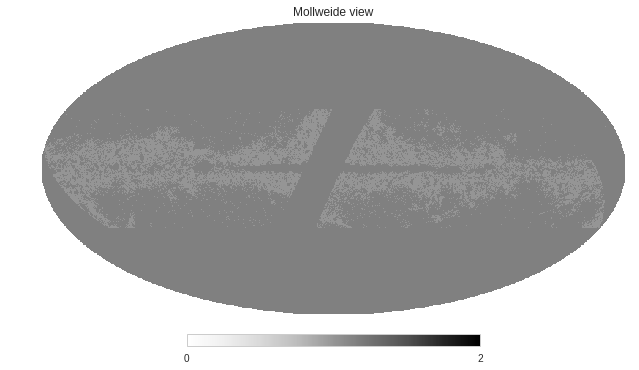

In [552]:
hp.mollview(mask_all, nest=True)

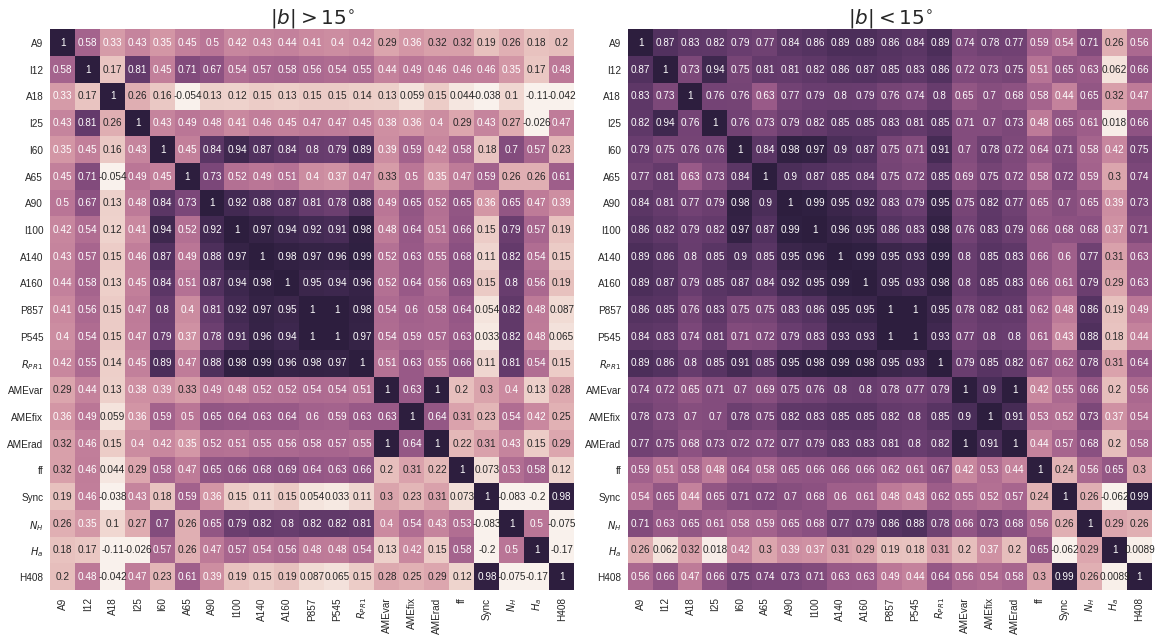

In [553]:
plotCorrMatrix(
   phot_mpsub.join(planck_bb['$R_{PR1}$']).join(planck_mw).join(ancillframe),
    pixmask = mask_all,
    pdf_suffix = 'intensity_maskall'
               )

Now we compare the spearman correlation scores among all of the IR bands, and the AME. We do this for for 3 different cases: 

  * Intensity
  * Intensity / U
  * Intensity / R 

In [554]:
# Unnormalized intensity correlations matrix:

### Radiation field normalized correlations matrix:

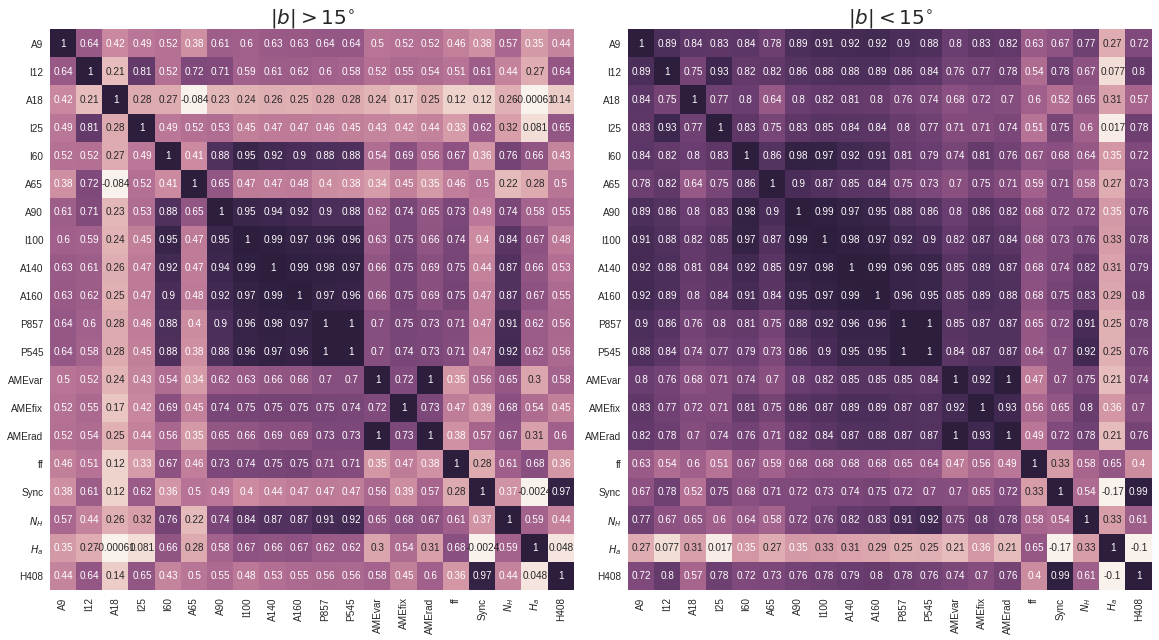

In [555]:
plotCorrMatrix(  
                (
                   phot_mpsub.join(planck_mw).join(ancillframe)
                ).divide(
                    planck_bb['$U$'], axis=0),
    pixmask = mask_all,
                pdf_suffix = 'R_norm'
               )

### Opacity-normalized correlations matrix:

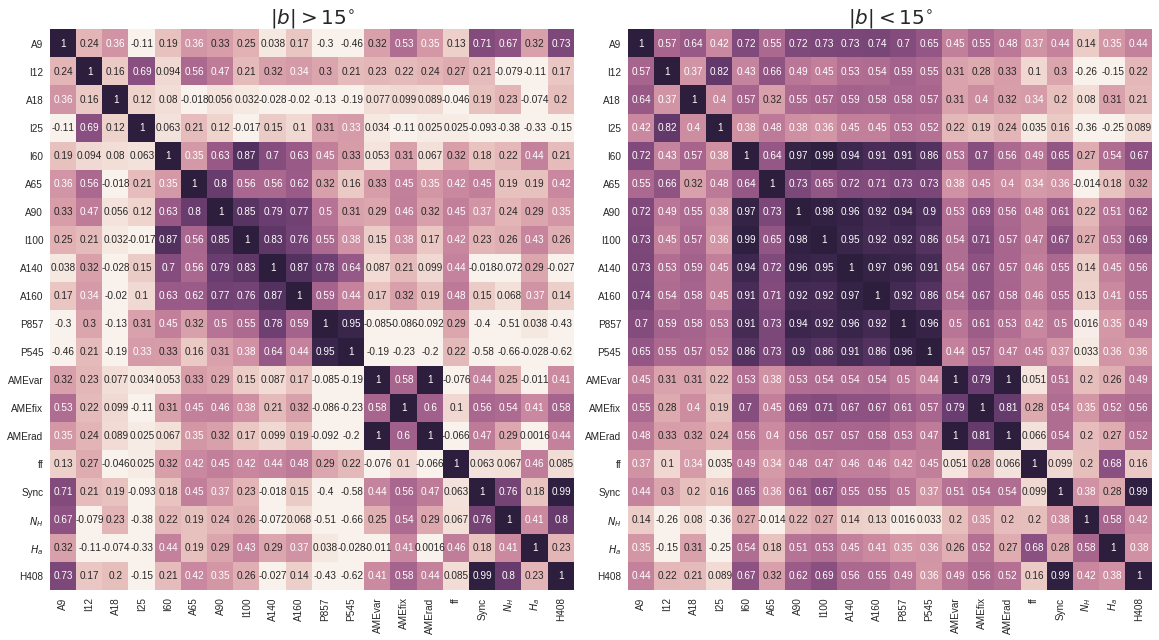

In [556]:
plotCorrMatrix(  
                (
                    phot_mpsub.join(planck_mw).join(ancillframe)
                ).divide(
                    planck_bb['$\tau_{353,PR1}$'], axis=0),
    pixmask = mask_all,
                pdf_suffix = 'tau_norm_maskall'
               )

### Radiance noramlized correlations matrix:

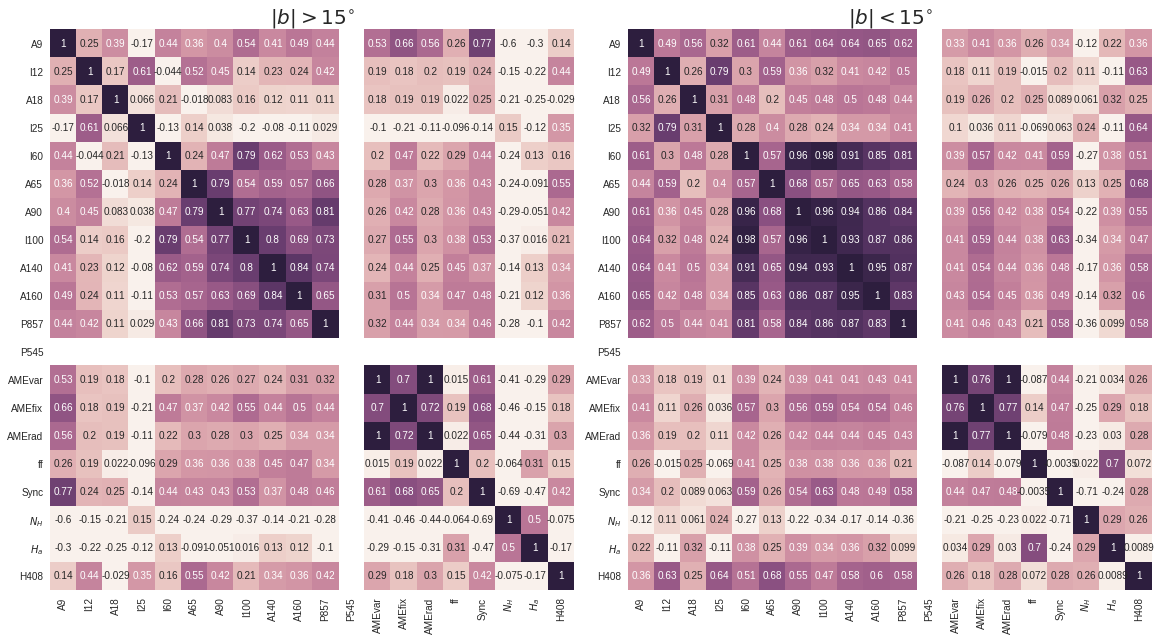

In [557]:
plotCorrMatrix(  
                (phot_mpsub.join(planck_mw))
            .divide(phot_mpsub['P545'],axis=0)
            .join(ancillframe),
            pixmask=mask_all,
                pdf_suffix = 'R_norm'
               )

# All-sky AME vs. IR plots:

In [558]:
def plotBandsCloud(xframe, yseries, xlabel, ylabel, xylims, outpath, nside=256, sharex=True, sharey=True):
    
    sb.set_style("whitegrid")

    ncols=4
    nrows=3
    aspect=1.0

    fig, axs = plt.subplots(ncols=ncols, 
                            nrows=nrows, 
                            sharey=sharey, 
                            sharex=sharex)
    #fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
    plt.setp(axs.flat, aspect=1.0, adjustable='box-forced')

    k=0

    hsize = np.size(yseries)#hp.nside2npix(nside)
    
    randsub = np.random.randint(low=0, high=hsize, size=hsize//100)


    for i in range(0,nrows):
        for j in range(0,ncols):
                
                #print k
                
                if k > (ncols*nrows-1):

                    pass

                else:

                    x = xframe[xframe.columns[k]].iloc[randsub]


                    y = yseries.iloc[randsub]

                    x_ = x[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()
                    y_ = y[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()

                    x_ = np.log10(x_).values
                    y_ = np.log10(y_).values

                    ax = axs[i,j]

                    sb.kdeplot(
                           x_,
                           y_,
                           shade=True,
                           shade_lowest=False,
                           gridsize=200,
                            ax = ax)



                    #ax.axis([xmin, xmax, ymin, ymax])
                    ax.axis(xylims)

                    ax.text(0.2, 0.9,xframe.columns[k], horizontalalignment='center',
                      verticalalignment='center',
                      transform=ax.transAxes, 
                      fontsize=15)

                    ax.grid(True)

                    ax.set_frame_on(True)

                    k += 1
                    
        ax = axs[-1,0]
        ax.set_ylabel(ylabel, fontsize=15)
        ax = axs[-1,0]
        ax.set_xlabel(xlabel, fontsize=15)

        fig.show()

        fig.savefig(outpath, bbox_inches='tight')
        fig.savefig(outpath[:-4]+".png", bbox_inches='tight')

                    
    return axs
    


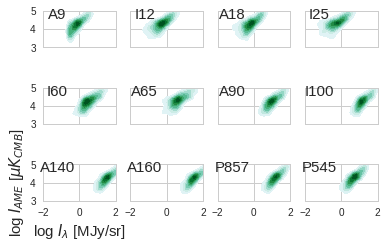

In [562]:
axs = plotBandsCloud(
                xframe = phot_mpsub.iloc[mask_all!=hp.UNSEEN], 
               yseries = planck_mw['AMEvar'].iloc[mask_all!=hp.UNSEEN],
                ylabel = 'log $I_{AME}$ [$\mu{}K_{CMB}$]',
                xlabel = 'log $I_{\lambda}$ [MJy/sr]',
                xylims = [-2,2, 
                          3,5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub_kde.pdf"
)

In [ ]:
xframe = phot_mpsub.divide(phot_mpsub['P545'], axis=0)
yseries = planck_mw['AMEvar']
axs = plotBandsCloud(
                xframe = xframe, 
               yseries = yseries,
                ylabel = 'log $I_{AME}$',
                xlabel = 'log $I_{\lambda}$ / $R$ ',
                xylims = [-2,5,-3,3],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub_Rnorm_kde.pdf"
)

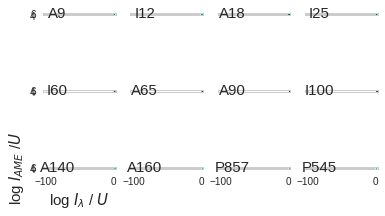

In [561]:
axs = plotBandsCloud(
                xframe = phot_mpsub.divide(planck_bb['$U$'], axis=0), 
               yseries = planck_mw['AMEvar'].divide(planck_bb['$U$'], axis=0),
                ylabel = 'log $I_{AME}$ /$U$',
                xlabel = 'log $I_{\lambda}$ / $U$',
                xylims = [-105,2.5,3.5,6.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands_mpsub_UNorm_kde.pdf"
)

# Check spatial correlations:

In [308]:
def testSpatialCorr(df, 
                    nside_in, 
                    nside_out,
                    method='spearman'):
    
    npix_in    = 12*nside_in**2
    npix_out   = 12*nside_out**2
    pix_interv = (nside_in/nside_out)**2
    
    ## First, do it the "normal way"-
    patches_corr = [df.iloc[i*pix_interv:(i+1)*pix_interv].corr(method=method) for i in range(0,npix_out)]
    corr_patches_pn = pd.Panel({i: patches_corr[i] for i in range(0,npix_out)})

    
    return corr_patches_pn

def displaySpatialCorr(corr_patches_pn,labels, ref_col=0,savefig=True,subdir='../Plots/Allsky_Corr/'):

    nside = len(corr_patches_pn.values[:,0,0])
    #fig = plt.figure(figsize=(8,4))

    for j in range(0,len(labels)):
        #plt.subplot(2,5,(j*2)+1)
        hp.mollview(corr_patches_pn.values[:,j,ref_col],
                         #sub=(1,4,j+1), 
                         #fig=fig,
                         cmap = cmap, 
                         cbar = False, 
                         min  = -1, 
                         max  = 1, 
                         nest = True, 
                         title="$S$({}:{}) NSIDE".format(labels[ref_col],labels[j],nside_out))
        hp.graticule(dpar=5, dmer=5,coord='G')
        if savefig==True:
            plt.savefig("{}/Spearman_Map_nside{}_{}to{}.pdf".format(subdir,nside_out,labels[ref_col],labels[j]) )

### Calculate all intensity correlations

In [315]:
%%capture
nside_in = 256
nside_out = 8
test_frame = phot_mpsub.join(planck_mw)
# Makes all the correlation maps

corr_patches_pn = testSpatialCorr(test_frame,
                                  nside_in, 
                                  nside_out)

for i in range(0,len(test_frame.columns)):
    displaySpatialCorr(corr_patches_pn, test_frame.columns, ref_col = i)

#### Get I12-normalized correlations

In [312]:
nside_in = 256
nside_out = 8
test_frame_I12norm = phot_mpsub.drop(['I12'],axis=1).join(planck_mw).divide(phot_mpsub['I12'], axis=0)
corr_patches_pn_I12norm = testSpatialCorr(test_frame_I12norm,
                                  nside_in, 
                                  nside_out)

##### Display just the A9:all correlations

In [313]:
%%capture
displaySpatialCorr(corr_patches_pn_I12norm, 
                   test_frame_I12norm.columns, 
                   ref_col = 0,
                   subdir='../Plots/Allsky_Corr/I12Norm',
                   savefig=False)

### Get the R-normalized correlations

In [ ]:
planck_mw.f

In [316]:
%%capture
nside_in = 256
nside_out = 8
test_frame_Rnorm = phot_mpsub.join(
    planck_mw['AME']).divide(
        planck_bb['$R_{PR1}$'], axis=0).join(planck_mw[['Sync','ff']])

corr_patches_pn_Rnorm = testSpatialCorr(test_frame_Rnorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
#### Display just the A9:all correlations

In [180]:
test_frame_Rnorm.columns

Index([u'A9', u'I12', u'A18', u'I25', u'I60', u'A65', u'A90', u'I100', u'A140',
       u'A160', u'P857', u'P545', u'AME', u'Sync', u'ff'],
      dtype='object')

In [319]:
%%capture
displaySpatialCorr(corr_patches_pn_Rnorm, 
                   test_frame_Rnorm.columns, 
                   ref_col = -3,
                   subdir='../Plots/Allsky_Corr/RadNorm',
                   savefig=True)

In [ ]:
from scipy.stats import zscore


def sigmaClip(df, zs = 3):

     df.values[zscore(df.values, axis=0) > zs] = np.nan
    
     return df

def displayRatioMap(df1,df2, nest = True, cmap = "rainbow"):
    
    ratio = df1 / df2
    
    hp.mollview(sigmaClip(ratio), 
                nest = nest, 
                norm = 'log', 
                cmap =cmap, 
                notext= True,
                min=0.2, 
                max = 10,
                title = '',
                xsize = 1000)
    plt.show()
    
    plotClippedHist(ratio)

        

    

displayRatioMap(phot_mpsub['A9'] ,
                phot_mpsub['I12'],
               cmap = cmap)
    


# 9 to 12 micron ratio map:

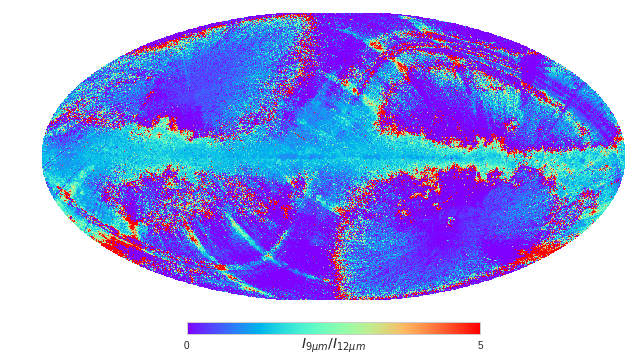

In [566]:
hp.mollview( phot_mpsub['A9'] / phot_mpsub['I12'], 
            min=0, 
            max = 5, 
            nest= True, 
            #norm = 'symlog',
            cmap=cmap,
            title = '',
            xsize = 1000,
            unit = '$I_{9\mu{}m} / I_{12\mu{}m}$')
plt.savefig('../Plots/ch_datasources/ratioMap_A9I12.pdf')

In [ ]:
# 9 to 18 micron ratio map:

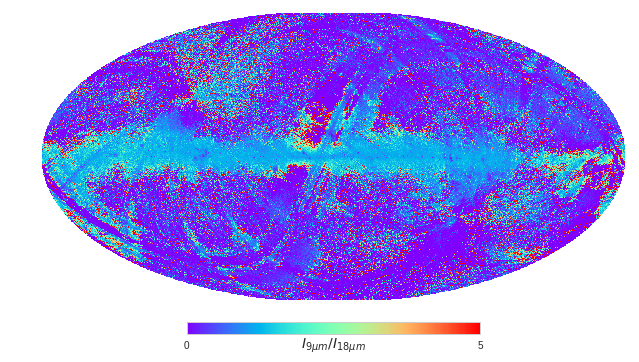

In [567]:
hp.mollview( phot_mpsub['A9'] / phot_mpsub['A18'], 
            min=0, 
            max = 5, 
            nest= True, 
            #norm = 'symlog',
            cmap=cmap,
            title = '',
            xsize = 1000,
            unit = '$I_{9\mu{}m} / I_{18\mu{}m}$')
plt.savefig('../Plots/ch_datasources/ratioMap_A9A18.pdf')

# 9 to 25 micron ratio map:

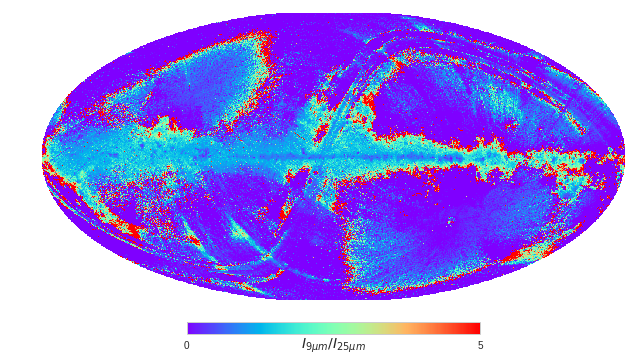

In [401]:
hp.mollview( phot_mpsub['A9'] / phot_mpsub['I25'], 
            min=0, 
            max = 5, 
            nest= True, 
            #norm = 'symlog',
            cmap=cmap,
            title = '',
            xsize = 1000,
            unit='$I_{9\mu{}m} / I_{25\mu{}m}$')
plt.savefig('../Plots/ch_datasources/ratioMap_A9I25.pdf')

In [568]:
# 12 to 25 micron ratio map:

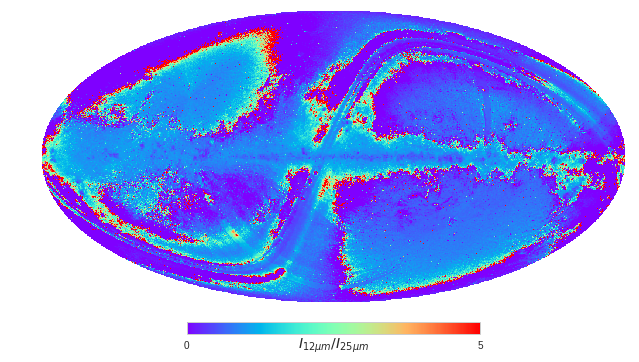

In [569]:
hp.mollview( phot_mpsub['I12'] / phot_mpsub['I25'], 
            min=0, 
            max = 5, 
            nest= True, 
            #norm = 'symlog',
            cmap=cmap,
            title = '',
            xsize = 1000,
            unit='$I_{12\mu{}m} / I_{25\mu{}m}$')
plt.savefig('../Plots/ch_datasources/ratioMap_I12I25.pdf')

In [403]:
phot_mpsub_sclip.head()

A9        I12         A18        I25         I60         A65  \
0  32.576195        NaN  161.111088        NaN         NaN  839.000925   
1  16.211823        NaN   15.641566  27.124137  122.780444   96.356317   
2  15.660368        NaN   13.058396  20.603543   90.007212   89.990480   
3  12.852653   9.948460   11.180863  16.977584   69.936061   74.502397   
4  13.925347  10.900413   11.847739  17.895793   86.984736   91.578523   

          A90        I100         A140         A160  P857  P545  
0  865.553208         NaN  1377.629917  1262.239443   NaN   NaN  
1  234.139863         NaN   746.628696   737.239504   NaN   NaN  
2  204.754395  305.085720   693.714451   741.075320   NaN   NaN  
3  162.342179  238.519070   562.862766   605.167910   NaN   NaN  
4  203.710633  284.816189   629.651157   644.891604   NaN   NaN

In [325]:
pd.DataFrame(zscore(phot_modesub.replace(to_replace=np.nan, value=hp.UNSEEN, axis=0)), columns=phot.columns).describe()

A9           I12           A18           I25           I60  \
count  7.864320e+05  7.864320e+05  7.864320e+05  7.864320e+05  7.864320e+05   
mean  -1.106347e-13  2.548033e-16 -1.106347e-13 -2.416006e-16  1.313833e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -1.883750e+01 -3.089935e-01 -1.883750e+01 -1.980559e-01 -1.050080e-01   
25%    5.308559e-02 -1.450608e-01  5.308559e-02 -6.464853e-02 -7.769668e-02   
50%    5.308559e-02 -1.009900e-01  5.308559e-02 -4.464437e-02 -7.119701e-02   
75%    5.308559e-02 -4.143122e-02  5.308559e-02 -2.405516e-02 -5.144976e-02   
max    5.308559e-02  2.599272e+02  5.308559e-02  3.728086e+02  2.320100e+02   

                A65           A90          I100          A140          A160  \
count  7.864320e+05  7.864320e+05  7.864320e+05  7.864320e+05  7.864320e+05   
mean   4.580667e-14  4.258941e-14  9.327504e-16 -3.364212e-14  3.495937e-15   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -7.631790e+01 -7.899699e+01 -1.493428e-01 -1.457872e+02 -1.352336e+02   
25%    1.310309e-02  1.265871e-02 -1.328474e-01  6.859311e-03  7.394614e-03   
50%    1.310309e-02  1.265871e-02 -1.167846e-01  6.859311e-03  7.394614e-03   
75%    1.310309e-02  1.265871e-02 -6.799565e-02  6.859311e-03  7.394614e-03   
max    1.310309e-02  1.265871e-02  1.338912e+02  6.859311e-03  7.394614e-03   

               P857          P545  
count  7.864320e+05  7.864320e+05  
mean   9.045544e-16 -1.005649e-15  
std    1.000001e+00  1.000001e+00  
min   -2.488448e-01 -2.808664e-01  
25%   -2.234617e-01 -2.495869e-01  
50%   -1.907863e-01 -2.122845e-01  
75%   -8.368784e-02 -8.735129e-02  
max    1.348582e+02  1.236430e+02

In [321]:

phot_modesub_zscore = pd.DataFrame(
    zscore(phot_modesub.replace(
        to_replace=np.nan, 
        value=hp.UNSEEN, 
        axis=0)), 
    columns=phot.columns)


phot_modesub_sclip[(abs(phot_modesub_zscore) > 5) & (phot_modesub_sclip < 0) ] = np.nan

NameError: name 'zscore' is not defined

In [206]:
hp.mollview(phot_modesub_sclip.A9 / phot_modesub_sclip.I12, min =0.01 , max = 1000, 
            nest=True, norm = 'log', cmap=cmap)

NameError: name 'phot_modesub_sclip' is not defined

In [320]:
hp.mollview(phot_modesub_sclip.A9 / planck_bb['$R_{PR1}$'],  
            nest=True, norm = 'hist', min=0, cmap=cmap)

NameError: name 'phot_modesub_sclip' is not defined

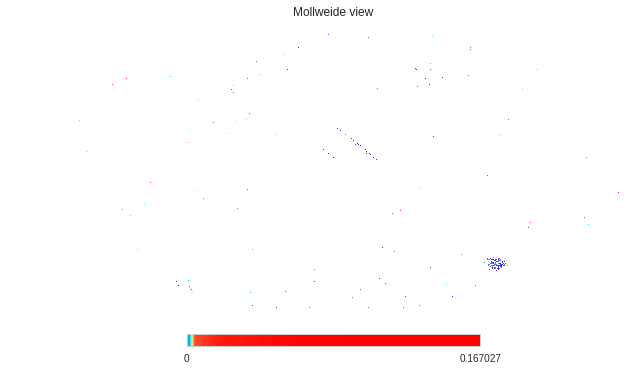

In [484]:
hp.mollview(phot_modesub_sclip.A9 / planck_mw['AMEvar'],  
            nest=True, norm = 'hist', cmap=cmap, min=0)

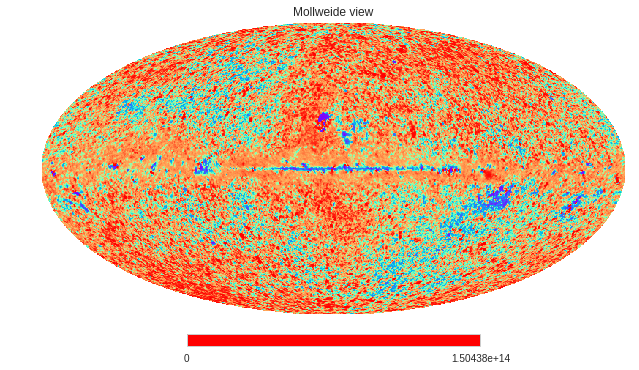

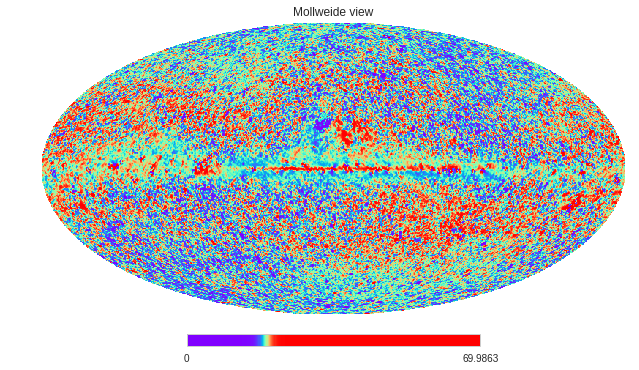

In [487]:
hp.mollview(planck_mw['AMEvar'] / planck_bb['$R_{PR1}$'],  
            nest=True, norm = 'hist', cmap=cmap, min=0)

hp.mollview(planck_mw['AMEfreq'],  
            nest=True, norm = 'hist', cmap=cmap, min=0)

In [114]:
hp.mollview(phot_mpsub['A9'])

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [ ]:
hp.mollview( phot_mpsub['A9'].values[phot_mpsub['A9'].values>=0] / phot_mpsub['I25'].values[phot_mpsub['A9'].values>=0], nest= True, norm = 'hist')

In [ ]:
sb.joinplot(planck_mw['AME']/hframe['4.57e5'],
           phot_mpsub)

In [21]:
hframe['N(H1)'] = hp.ud_grade(
    hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/radio/lambda_combined_nh.fits',
                                  nest=True),
    nside_out = 256,
    order_in = 'NESTED',
    order_out = 'NESTED',
    pess=True)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


In [ ]:
hp.mollview( planck_mw['AME']/radioframe['4.57e5'], nest= True, norm = 'hist'
)

In [ ]:
sb.jointplot

In [ ]:
nside_in = 256
nside_out = 8
test_frame_RadNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$R_{PR1}$'], axis=0)
corr_patches_pn_RadNorm = testSpatialCorr(test_frame_RadNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_RadNorm.columns)):
    displaySpatialCorr(corr_patches_pn_RadNorm, test_frame_RadNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [ ]:
nside_in = 256
nside_out = 8
test_frame_UNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$U$'], axis=0),
corr_patches_pn_UNorm = testSpatialCorr(test_frame_UNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_UNorm.columns)):
    displaySpatialCorr(corr_patches_pn_UNorm, test_frame_UNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [7]:
# All-sky Ionization fraction:
phot_mir_ratios = phot_mpsub.drop(['A9']).join(planck_bb['$R_{PR1}$']).join(planck_mw['$R_{PR1}$']).divide(phot_mpsub.A9)
   

NameError: name 'phot_mpsub' is not defined

In [ ]:
# The check appears successful, so make a plot grid of all the nsides:

## All-sky Noise Estimation:

In [ ]:
hmap_hists =  pd.DataFrame.hist(phot_modesub, 
                                range=(-10, 25), 
                                bins=100, 
                                alpha=0.4, 
                                grid=True,
                                sharex=True, 
                                xlabelsize=15,
                                sharey=False,
                                ylabelsize=12,
                                figsize=(11,8.5),
                                **{'normed':True})
hmap_hists

In [ ]:
def plot_hdists(df):
    
    import seaborn as sns
    import scipy.stats as stats
    sns.distplot(df, bins=1000, kde=False, fit=stats.gamma )
    print 
    
plot_hdists(phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna())

In [ ]:
data = phot_modesub.dropna().values[:,0]
# phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna()
# data.std()


In [ ]:
from astropy.modeling import models, fitting

def fitAndPlot(data, ymax=2.0, nbins=1000, amplitude =1, stddev = 1, mean=0, zero_mean=False, left_wing=False, left_mean=False, xrange=(-10,10)):
    

    # Get distribution
    y,x, patches = plt.hist(data, range=xrange, bins=nbins, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=amplitude, mean=mean, stddev=stddev)
    g_init.mean.fixed = zero_mean
    g_init.stddev.bounds = (0,None)
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.mean(data)], y[x[:-1]<np.mean(data)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black',alpha=0.8)



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,ymax)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,ymax/4,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,(ymax*5)/8,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)
    
    return g.stddev.value

# fitAndPlot(data)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=True)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=False, left_wing=True)
# plt.show()
# plt.close()
fitAndPlot(data, left_mean=True)
plt.show()
plt.close()
    
# Select data

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_mw.AME.dropna().values-0, range =(-30,150),bins=1000, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=0, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])

plt.plot(x,g(x),label='Gaussian', color='black')

plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)


print np.size(planck_mw.AME.dropna()==0)

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_bb['$T$'].dropna().values, range =(0,50),bins=100, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=20, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1], y)

plt.plot(x,g(x),label='Gaussian', color='black')



# Plot the data with the best-fit model
# plt.figure(figsize=(8,5))
# plt.plot(x, y[:-1], 'ko')
# plt.plot(x, g(x), label='Gaussian')
#plt.ylim(0,2.0)
plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)
#plt.text(60,0.008,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
#plt.text(60,0.006,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)

#print np.size(planck_mw.T.dropna()==0)

In [ ]:
## Whole sky without mean-fixing or wing-selection

In [ ]:
stddevs = []
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+".pdf", bbox_inches='tight', dpi=100)
    plt.show()
 

In [ ]:
## Whole sky with mean fixed to zero, using only the left wing

In [ ]:
stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=True, left_wing=True)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

## Noise estimated for limited patches:

#### Patch 1: (l:130, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
stddevs = []

noise_patches = [(coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5)]

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[0]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False,
                        left_mean=False,                        
                        nbins=400, 
                        xrange=(-4,4))
    
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_noisePatch1.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

#### Patch 2: (l:230, b:-60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[1]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch2.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

#### Patch 3: (l:230, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[2]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch3.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

In [ ]:
#### All 3 patches merged together:

noise_patches_merged = ((coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5) )


for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches_merged].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(np.random.choice(data, size=len(noise_patches_merged)//1),
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_mean=False,                        
                        nbins=1000, 
                        xrange=(data.min(),5))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatchMerged.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

## Estimate noise for a limited part of the sky: Planck CMB Mask

#### Masking test

In [ ]:
data =  phot_modesub.A9.values.copy
hp.mollview(data)
print len(data[np.isnan(data)==True])
hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')
data[hmask==hp.UNSEEN] = np.nan
print len(data[np.isnan(data)==True])
print len(hmask[hmask==hp.UNSEEN])

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMaskedTest(data,zero_mean=False, left_wing=False, left_mean=False):
    
    hp.mollview(data.values)
    plt.show()
    plt.close()
    
    data_unmask = data.copy()
    data_mask   = data.copy()
    
    data_unmask = data_unmask.dropna().values

    # Get distribution

    y,x, patches = plt.hist(data_unmask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_unmask)], y[x[:-1]<np.median(data_unmask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_unmask),5)),fontsize=22)
    plt.show()
    plt.close()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan
    hp.mollview(data_mask)
    plt.show()
    plt.close()
    
    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value

  
fitAndPlotMaskedTest(phot_modesub.A9.copy(), zero_mean=True, left_wing=True)
plt.show()
plt.close()

    
# Select data

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMasked(data,zero_mean=False, left_wing=False, left_mean=False):
    

    data_mask   = data.copy()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan

    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value


stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[phot_modesub.columns[i]].copy()
    stddev = fitAndPlotMasked(data, zero_mean=True, left_wing=True)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_masked.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
    
# Select data

## Offset Uncorrected Maps:

In [ ]:
stddevs = []

for i in range(0,len(phot.columns)):
    data = phot.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=False, left_wing=False, left_mean=True)
    stddevs.append(stddev)
    plt.title(phot.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot.columns[i]+"_nonOffsetCorr_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


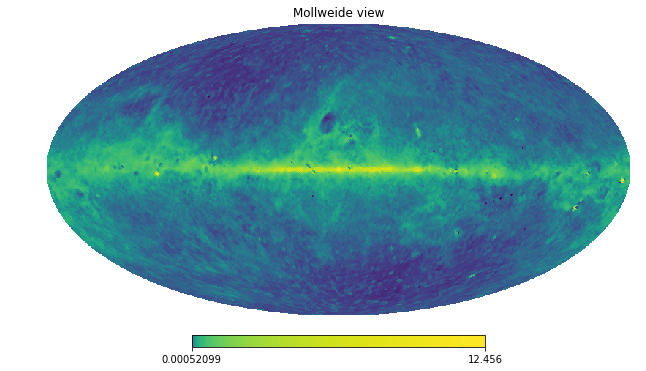

In [43]:
wmap_spd = hp.read_map(
    '/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/raw/wmap_mcmc_sd_k_spin_dust_temp_7yr_v4p1.fits',
    nest=True)
wmap_spd[wmap_spd==hp.UNSEEN] = np.nan

hp.mollview(wmap_spd, 
            nest=True,
           norm ='log')

In [44]:
wmap_planck_spdust = hp.ud_grade(planck_mw['AME'],
                                 nside_out=64,
                                 order_in = 'NESTED',
                                 order_out = 'NESTED') / wmap_spd

#sb.joinplot()

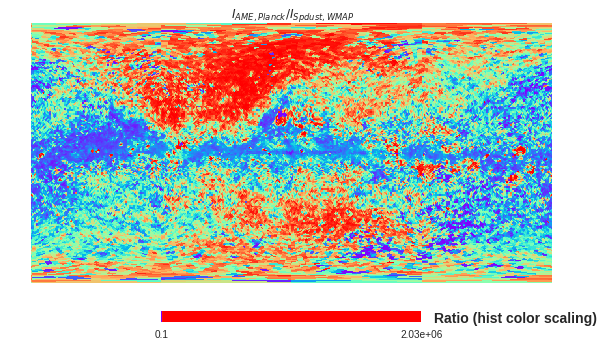

In [234]:
hp.cartview(wmap_planck_spdust, 
            norm='hist',
            min=0.1,
            nest=True,
            title = " $I_{AME, Planck} / I_{Spdust, WMAP}$",
            unit="Ratio (hist color scaling)",
            cmap =cmap)

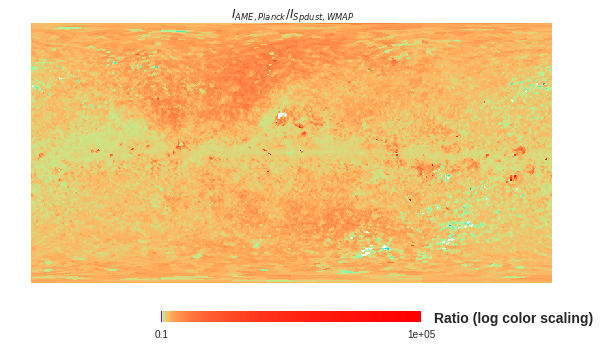

In [243]:
hp.cartview(wmap_planck_spdust, 
            norm='log',
            min=0.1,
            max = 1e5,
            nest=True,
            title = " $I_{AME, Planck} / I_{Spdust, WMAP}$",
            unit="Ratio (log color scaling)",
            cmap =cmap)

In [245]:
planck_spd_n64 = hp.ud_grade(planck_mw['AME'],
                                 nside_out=64,
                                 order_in = 'NESTED',
                                 order_out = 'NESTED')


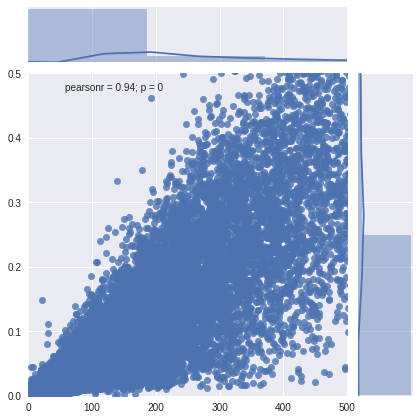

In [230]:
import seaborn as sb


sb.jointplot(   
            planck_spd_n64,
            wmap_spd,
            kind = 'reg',
            dropna =True,
            xlim = (0,500),
            ylim = (0,0.5)
            )

# Bootstrap it:

In [570]:
import numpy.random as npr
from scipy import stats

def bootstrap(data_x, 
              data_y, 
              iterations,  
              kind='Pearson'):
    
    
    #"""Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    
    #data_x_dropna = data_x[(np.isfinite(data_x)==True) & (np.isfinite(data_y)==True)].copy()
    #data_y_dropna = data_y[(np.isfinite(data_x)==True) & (np.isfinite(data_y)==True)].copy()
    
    
    nx = len(data_x)
    ny = len(data_y)

    print "Found {} valid samples (not NaN)".format(nx)
    #print "Found {} valid samples (not NaN)".format(ny)
    #print data_x_dropna
    
    corr_coeff_array = np.ones(iterations)
    
    if kind == 'Spearman':
    
        for i in range(0,iterations):
            
            idx = npr.randint(0, nx, nx)

            stat_r, stat_p = scipy.stats.spearmanr(data_x.iloc[idx],
                                                   data_y.iloc[idx])
            corr_coeff_array[i] = stat_r
    
    elif kind == 'Pearson':
            
        for i in range(0,iterations):
            
            idx = npr.randint(0, nx, nx)
            stat_r, stat_p = scipy.stats.pearsonr(data_x.iloc[idx],
                                                  data_y.iloc[idx])
            corr_coeff_array[i] = stat_r

    #print corr_coeff_array
    return corr_coeff_array



def bootstrap_run(X1_data, 
                  X2_data, 
                  Y_data,
                  kind='Pearson', 
                  iterations=10000, 
                  title=None, 
                  X1_label=None, 
                  X2_label=None,
                  ftitle='Bootstrap' ):
    
        ## Force background color to be white:
    ### Note that seaborn plotting functions my override these settings.
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    
    
    corr_array_X1 = bootstrap( X1_data,
                               Y_data, 
                               iterations, 
                               kind=kind)

    corr_array_X2 = bootstrap( X2_data,
                               Y_data, 
                               iterations, 
                               kind=kind)
    
    X1 = corr_array_X1.copy()
    X2 = corr_array_X2.copy()
    
    
    #print len(X1)
    #print len(X2)
    
    t, prob = scipy.stats.ttest_ind(X1,
                                    X2, 
                                    axis=0, 
                                    equal_var=True) #Equal_var=False for Welch's t-test
    # make plots
    
    plt.figure(figsize=(6,6))

    round_it = 3

    bins = np.linspace(0.5, 1.0, 100)

    plt.hist(X1, bins, alpha=0.5, color= 'r', label=X1_label +" "+ 
                                           str(round(np.nanmean(X1),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X1),round_it)) )
    plt.hist(X2, bins, alpha=0.5, color= 'b', label=X2_label+" "+ 
                                           str(round(np.nanmean(X2),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X2),round_it))
                                            + "\n" + "t-stat: "+ 
                                                       str(round(t,1))+", p-value: "+   str(round(prob,6)))
    plt.ylabel("Count", fontsize=20)
    plt.xlabel("$r_{s}$", fontsize=20)

    
    plt.legend(loc='upper left')
    
    #plt.savefig("../Plots/"+ftitle)
    plt.show()


     

In [596]:
#%%timeit

all_bootstraps_spearman = pd.DataFrame()

bootframe = phot_modesub.join(planck_mw['AMEvar']).dropna()

for band in bootframe.drop('AMEvar',axis=1).columns:
    all_bootstraps_spearman[band] = bootstrap(bootframe[band],
                            bootframe['AMEvar'],
                            1000,
                            kind='Spearman')
    


Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)
Found 784086 valid samples (not NaN)


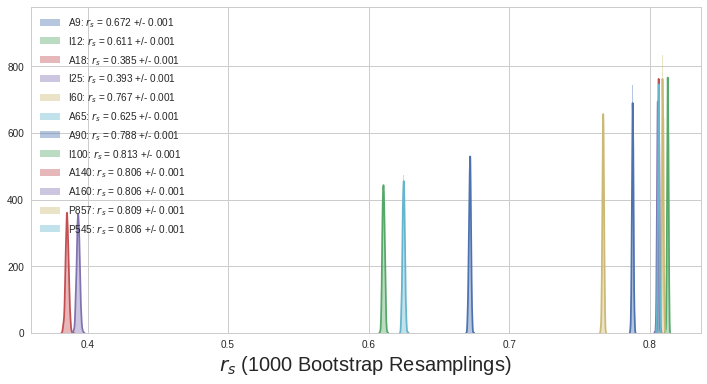

In [ ]:
plt.figure(figsize=(12,6))
for band in (all_bootstraps_spearman.columns):
    
    sb.distplot(all_bootstraps_spearman[band], 
                label=band+': $r_s$ = {} +/- {}'
                    .format(round(np.mean(all_bootstraps_spearman[band]),3),
                            round(np.std(all_bootstraps_spearman[band]),3)
                                ))
    #plt.text(np.mean(lori_bootstraps[band]), 90, band)
plt.xlabel('$r_s$ (1000 Bootstrap Resamplings) ',  fontsize = 20)
plt.legend()
plt.savefig('../Plots/ch_allsky/bootstrap_vs_AME_spearman__allpix_i1000.pdf')

In [ ]:
#%%timeit

maskall_bootstraps_spearman = pd.DataFrame()
bootframe_maskall = pd.DataFrame()
bootframe_maskall = (phot_modesub.join(planck_mw['AMEvar'])).copy()
bootframe_maskall[mask_all==hp.UNSEEN]=np.nan
bootframe_maskall = bootframe_maskall.dropna()

for band in bootframe.drop('AMEvar',axis=1).columns:
    maskall_bootstraps_spearman[band] = bootstrap(bootframe_maskall[band],
                            bootframe_maskall['AMEvar'],
                            10000,
                            kind='Spearman')
    


Found 104646 valid samples (not NaN)
Found 104646 valid samples (not NaN)
Found 104646 valid samples (not NaN)
Found 104646 valid samples (not NaN)
Found 104646 valid samples (not NaN)
Found 104646 valid samples (not NaN)


In [ ]:
plt.figure(figsize=(12,6))
for band in (maskall_bootstraps_spearman.columns):
    
    sb.distplot(maskall_bootstraps_spearman[band], 
                label=band+': $r_s$ = {} +/- {}'
                    .format(round(np.mean(maskall_bootstraps_spearman[band]),3),
                            round(np.std(maskall_bootstraps_spearman[band]),3)
                                ))
    #plt.text(np.mean(lori_bootstraps[band]), 90, band)
plt.xlabel('$r_s$ (1000 Bootstrap Resamplings) ',  fontsize = 20)
plt.legend()
plt.savefig('../Plots/ch_allsky/bootstrap_vs_AME_spearman_maskall_i10000.pdf')

In [ ]:
git